## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
register_matplotlib_converters()
from time import time
from utils import utils

In [2]:
fname = "csv_data/clean_data/jets_daily_15-19_clean.csv"
df = pd.read_csv(fname, index_col=0, squeeze=True)

In [3]:
df['return'].isnull().values.any()

False

## Retuns plot

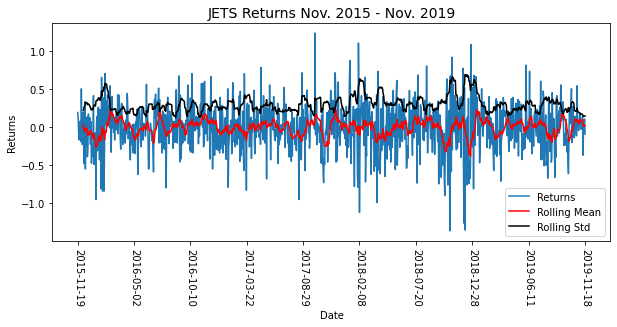

In [21]:
rolling_mean = df['return'].rolling(window=12).mean()
rolling_std = df['return'].rolling(window=12).std()

x_idx, x_dates = utils._get_x_dates(df['Date'])
plt.figure(figsize=(10, 4))
plt.plot(df['return'], label='Returns')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.xticks(x_idx, x_dates, rotation=-90)
plt.title('JETS Returns Nov. 2015 - Nov. 2019', fontsize=14)
plt.legend()
plt.ylabel('Returns', fontsize=10)
plt.xlabel("Date")
plt.show()

## Stationarity Analysis

In [5]:
def get_stationarity(timeseries):
    
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # plot rolling stats
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dicky-Fuller Test 
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print('Critical Values')
    for k, v in result[4].items():
        print(f"\t{k}: {v}")

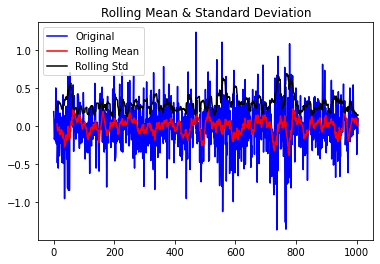

ADF Statistic: -7.207624112440697
p-value: 2.2783185400296593e-10
Critical Values
	1%: -3.436979275944879
	5%: -2.8644668170148058
	10%: -2.5683283824496153


In [6]:
get_stationarity(df['return'])

### Since p-value is high and critical values are not close to ADF statistic, we say that this time series is not stationary

In [7]:
df_cube = np.sign(df['return']) * np.power(np.abs(df['return']), 1/3)
df_cube[0], df['return'][0], df['return'][0]**(1./3)

(0.5748907164711509, 0.1900010000000023, 0.5748907164711509)

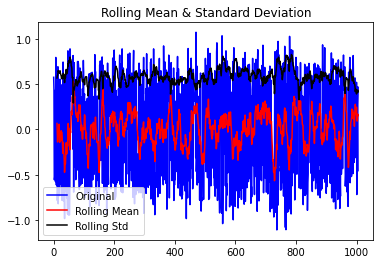

ADF Statistic: -32.55357326178004
p-value: 0.0
Critical Values
	1%: -3.4368734638130847
	5%: -2.8644201518188126
	10%: -2.5683035273879358


In [8]:
get_stationarity(df_cube)

### Transforming the data to a cubic scale does not provide a stationary time series

## PACF and ACF

#### The ACF/PACF plot helps us determine which lag(s) are most important for the AR process (we see below that lag 1 has the most impact (2 and 3 also have importance)

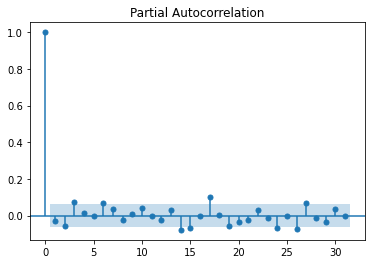

In [9]:
pacf_plot = plot_pacf(df['return'])

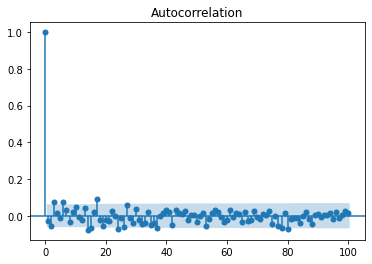

In [10]:
acf_plot = plot_acf(df['return'], lags=100)

#### We will introduce a 1 to introduce a 1 time differencing in order to make the distribution stationary

In [11]:
split = 0.9 # 90% train, 10% test
n_train = int(len(df)*split)

train_data = df['return'][:n_train]
test_data = df['return'][n_train:]

In [12]:
# create the model
model = ARIMA(train_data, order=(1, 1, 0))

In [13]:
# fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.11678099632263184


## Model Summary
### notice that our model parameters are all significant (pass the p-value test)

In [14]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                  905
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -458.230
Date:                Sun, 29 Nov 2020   AIC                            920.459
Time:                        04:33:31   BIC                            930.073
Sample:                             0   HQIC                           924.131
                                - 905                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4922      0.023    -21.187      0.000      -0.538      -0.447
sigma2         0.1613      0.006     28.943      0.000       0.150       0.172
Ljung-Box (L1) (Q):                  39.18   Jarque-

## View the fitted data

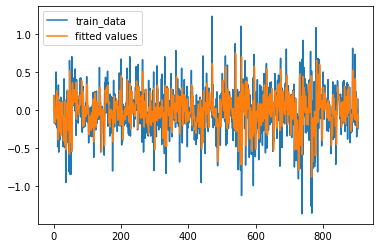

In [15]:
plt.plot(train_data, label='train_data')
plt.plot(model_fit.fittedvalues, label='fitted values')
plt.legend()
plt.show()

## Rolling Forecast

In [16]:
history = [x for x in train_data]
predictions = []
for t in range(len(test_data)):
    model = ARIMA(history, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t+len(train_data)]
    history.append(obs)
#     print(f"predicted {yhat} expected {obs}")
error = mean_squared_error(test_data, predictions)

In [17]:
error

0.1061432563955524

## Plot the predicted values and residuals

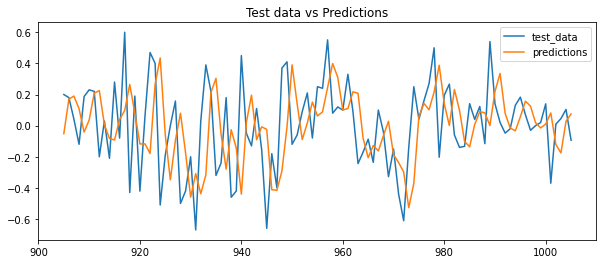

In [18]:
plt.figure(figsize=(10, 4))
plt.title('Test data vs Predictions')
plt.plot(test_data, label='test_data')
plt.plot(test_data.index, predictions, label='predictions')
plt.legend()
plt.show()

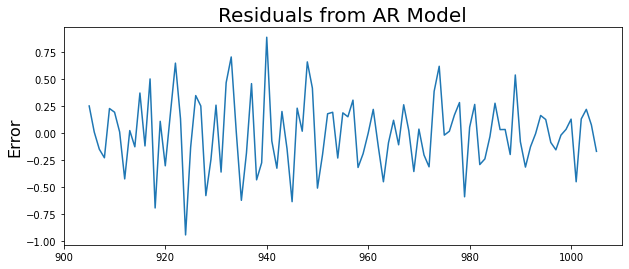

In [19]:
residuals = test_data-predictions
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel("Error", fontsize=16)
plt.show()

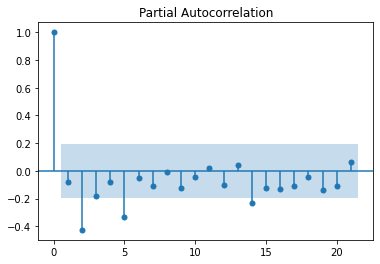

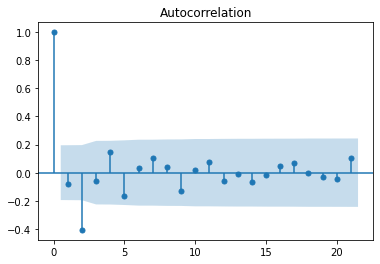

In [20]:
resid_pacf = plot_pacf(residuals)
resid_acf = plot_acf(residuals)